## Projet RCP216

### 0) Premières étapes

On met à jour certaines bibliotheques afin d'utiliser wordcloud

In [1]:
pip install wordcloud

     |████████████████████████████████| 520 kB 5.7 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 5.9 MB/s            
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 6.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1
Note: you may need to restart the kernel to use updated packages.


#### 1- Chargement des bibliothèques et lancement de spark 

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
#print(sys.executable)    # vérification
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
#os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.johnsnowlabs.nlp:spark-nlp_2.12:4.2.0'

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import Normalizer
import sparknlp
sparknlp.start()

:: loading settings :: url = jar:file:/srv/conda/envs/notebook/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1dcb0b82-134f-428f-8b97-c36580606718;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.2.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lom

24/04/08 13:02:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### II) Téléchargement et récupération des données

#### 1) On télécharge les données

In [2]:
#Recuperation/collecte des données :
if not os.path.exists("aclImdb_v1.tar.gz"):
    sortie = "téléchargement OK" if os.system("wget -nv -nc https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz")==0 else "Erreur lors du téléchargement"
    print (sortie)
else :
    print("dejà téléchargé")
#Extraction des données dans le répertoire /aclImdb: 
if not os.path.exists("/aclImdb"):    
    os.system("tar -xf "+"aclImdb_v1.tar.gz ")
else : "KO"

dejà téléchargé


#### 2) On récupère le texte d'entrainement
Dans le code ci-dessous, on rècupère les textes positifs et négatifs du dossier train (soit 25 000 textes).
On récupère également la note associée à chaque texte dans une nouvelle colonne du dataframe avec withcolumn:

In [3]:
from pyspark.sql.functions import lit
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.functions import input_file_name
from pyspark.sql.functions import regexp_extract 
#On récupère les données d'entrainement dans un dataframe avec la colonne texte et Note
texteNeg = spark.read.text("aclImdb/train/neg/*.txt").withColumn("note", regexp_extract(input_file_name(), r'_(\d+).txt', 1)).toDF("text","label")
textePos = spark.read.text("aclImdb/train/pos/*.txt").withColumn("note", regexp_extract(input_file_name(), r'_(\d+).txt', 1)).toDF("text","label")

In [4]:
#On fait une union des deux types de texte
texteNeg =texteNeg.withColumn("label", texteNeg.label.cast("integer"))
textePos= textePos.withColumn("label", textePos.label.cast("integer"))
TexteTrain= textePos.union(texteNeg).select("text", "label")

### III) Découverte et prétraitement des données 
Ici, on vérifie les données et on effectue certains prétraitements 

#### 1) Pré-traitement 

In [ ]:
#On compte notre texte
TexteTrain = TexteTrain.select("text","label")
TexteTrain.count()

25000

In [ ]:
#On regarde et on supprime les lignes en double (s'il y en a)
TexteTrain = TexteTrain.drop_duplicates()
TexteTrain.count()

24905

In [ ]:
#On supprime les lignes vides dans le dataframe (s'il y en a)
TexteTrain= TexteTrain.dropna()
TexteTrain.count()

24905

#### 2) Découverte des données avec Matplotlib et Seaborn

##### a- Répartition des textes en fonction de la note

In [ ]:
from pyspark.sql.functions import count
#Répartition des notes récupérées et stockage dans pandas: 
Notes = TexteTrain.groupby("label").agg(count("label")).toPandas() 

Text(0.5, 0, 'Note')

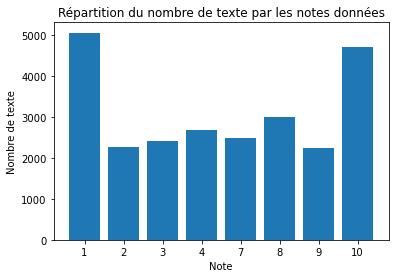

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

#On réorganise le dataframe afin d'afficher les valeurs correctement sous matplotlib
Notes['label'] = Notes['label'].astype(int) #Conversion en int pour appliquer le sort
Notes= Notes.sort_values(by='label')
Notes['label'] = Notes['label'].astype(str) #Reconversion en str

#Affichage de l'histogramme : 
fig, ax = plt.subplots() 
# get x and y data 
Texte= Notes['count(label)']
Note = Notes['label'] 
ax.bar(Note, Texte) 
ax.set_title('Répartition du nombre de texte par les notes données') 
ax.set_ylabel('Nombre de texte') 
ax.set_xlabel('Note')

In [ ]:
#On sauvegarde 
fig.savefig('images/1.Répartition du nombre de texte par les notes données.png')

On remarque dans cet histogramme qu'il y a une hétérogénité entre les notes (beaucoup de 10 et de 1), un échantillonnage sera nécessaire par la suite

##### b - Affichage du nombre de mots par texte (sans traitement)
Permet également de vérifier s'il y a des textes avec peu de mots ou à l'inverse beaucoup

Text(0, 0.5, 'Nombre de mots')

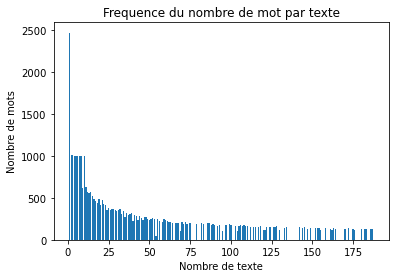

In [ ]:
#Calcul du nombre de mots par phrases
from pyspark.sql.functions import col, size, split

#Ajout d'une colonne comportant le nombre de mots par texte :
TexteTrain = TexteTrain.withColumn("nombre_de_mots", size(split(col("text"), " ")))
TextCount = TexteTrain.groupby("nombre_de_mots").agg(count("nombre_de_mots")).toPandas() 
TextCount.rename(columns={"count(nombre_de_mots)": "nombre_de_texte"}, inplace=True)

# creation du graph :
fig, ax = plt.subplots() 
# get x and y data 
x = TextCount["nombre_de_mots"]
y =  TextCount["nombre_de_texte"]
# create bar chart 
ax.bar(y, x) 
# set title and labels 
ax.set_title('Frequence du nombre de mot par texte') 
ax.set_xlabel('Nombre de texte') 
ax.set_ylabel('Nombre de mots')

In [ ]:
fig.savefig('images/2.Fréquence du nombre de mot par texte.png')

Sans aucun traitement, on peut voir que la majorité des textes ont généralement bien moins de 500 mots. En revanche, il existe des textes très longs (2500 mots mais en faible quantité). 
On affiche des boites à moustache ainsi que la mediane et la moyenne pour confirmer : 

La mediane est de :  174.0  et la moyenne  233.99164826340092


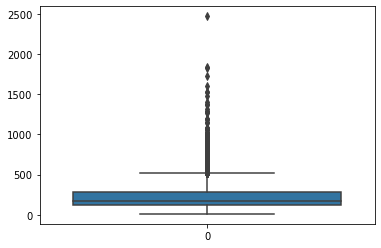

In [ ]:
import seaborn as sns
#On récupere le nombre de mots parmis les 25000 textes: 
box= TexteTrain.select("nombre_de_mots","label").toPandas()
box.rename(columns={"nombre_de_mots": "Nombre de mots", "label": "Note"}, inplace=True)
box["Note"] = box['Note'].astype(int) 
sns.boxplot(box["Nombre de mots"])
print("La mediane est de : ",box["Nombre de mots"].median()," et la moyenne ",box["Nombre de mots"].mean())

On regarde également, s'il peut exister un lien entre le nombre de mots d'une critique et la note qui lui est assignée. 
Quelqu'un qui n'est pas content du film pourrait être plus explicite sur le pourquoi le film n'est pas bon et inversement.

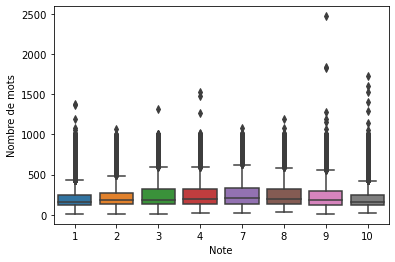

In [ ]:
boxplots = sns.boxplot(box, x="Note", y="Nombre de mots")
fig = boxplots.get_figure()
fig.savefig('images/3.boxplots.png')

Visuellement : 
- Cela ne semble pas très significatif.
- La plupart des textes ont un maximun de 500 à 600 mots en fonction de la note assignée.
- Les textes très négatifs (1) ou très positifs (10) ont en général un peu moins de mots
- En revanche, même s'il sont moins nombreux, il existe des textes qui sont assez long voire très long pour toutes les notes. 

##### c - Affichage des mots les plus courants

le code ci-dessous permet d'afficher des nuages de mots avec les 40 mots les plus courants pour tous les textes de chaque note. Les mots vides sont supprimés au cours de l'application de la méthode wordcloud.

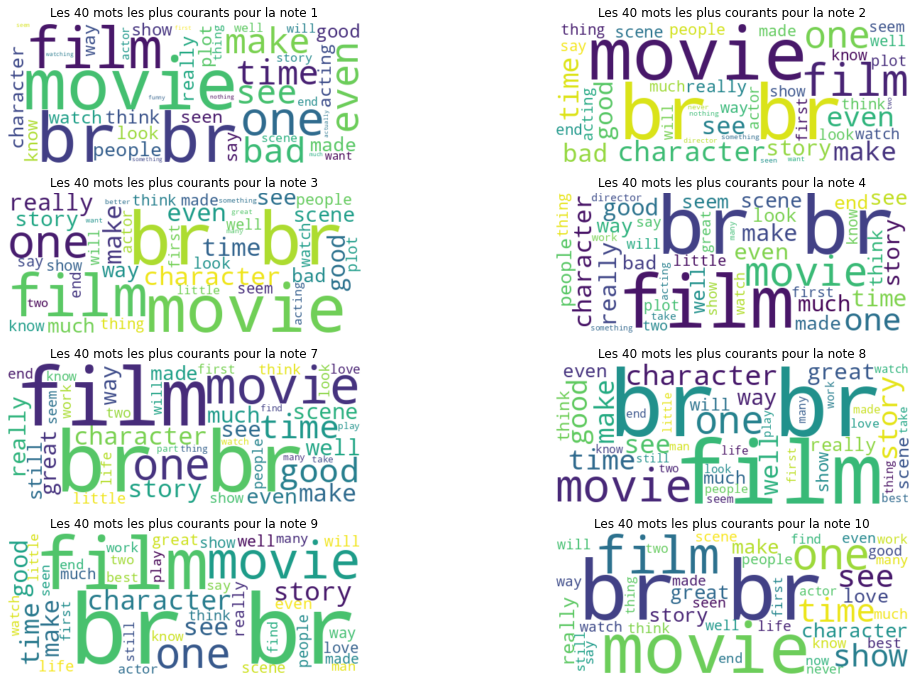

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
import numpy as np

fig, axs = plt.subplots(4, 2, figsize=(18, 12))
j=0
NotesUnique= TexteTrain.select("label").distinct().toPandas()
NotesUnique = NotesUnique.sort_values(by='label')
for i, note in enumerate(NotesUnique["label"]):
    textNote = TexteTrain.select("text").where(TexteTrain["label"]==note).toPandas()
    wordCloud = WordCloud(background_color = 'white', max_words = 40, width=500,height=200).generate(textNote.to_string())
    axs[j,i%2].imshow(wordCloud, interpolation='bilinear')
    axs[j,i%2].set_title((f'Les 40 mots les plus courants pour la note {note}'))
    axs[j,i%2].axis('off')
    if(i%2==1):
        j=j+1

In [ ]:
fig.savefig('images/4.wordcloud.png')

###### On peut remarquer plusieurs choses : 
- Des balises HTML "br" sont présentes dans le texte en grande quantité, on peut supposer que d'autres balises le sont également et un nettoyage sera peut-être nécessaire pour les retirer.
- Si certains mots sont communs entre les textes des différentes notes (movies, film, ... ), il est étonnant de retrouver des mots comme good pour des notes comme (1,2,3,4). 


En résumé, le premier parcours et nettoyage de données peut nous dit ceci : 
- Les textes ne sont pas homogènes (beaucoup plus de 10 et de 1) ;
- Certains textes étaient en double et ont été supprimés;
- Le nombre de mots utilisés pour la critique d'un film en fonction de la note donnée sont assez homogènes. Il existe cependant des  textes très longs; 
- Des balises HTML sont présentes dans les textes.

## III) Représentation vectorielle des textes
Ici, nous allons appliquer un ensemble de transformation sur nos textes avant de créer  les prédicteurs.
Plusieurs méthodes vont être utilisées : 
- Vectorisation avec pondération TF-IDF, 
- Encodages de textes à partir d’encodages Bert.

In [8]:
from pyspark.ml import Pipeline
from sparknlp.pretrained import PretrainedPipeline
from sparknlp import Finisher
from pyspark.sql.functions import col, lower
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from pyspark.ml.feature import HashingTF, IDF, StringIndexer, IndexToString
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import StringType
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler

### 1- Création du pipeline n°1 (Représentations vectorielles avec pondérations TF-IDF)

Paramètres du pipeline avec  TF-IDF :

In [9]:
#Transformation qui convertit les textes au format chaînes de caractères dans le format attendu par SparkNLP :
documentAssembler = DocumentAssembler() \
                      .setInputCol("text") \
                      .setOutputCol("document")

sentence = SentenceDetector() \
                  .setInputCols(["document"]) \
                  .setOutputCol("sentence")

#Création des jetons : 
tokenizer = Tokenizer() \
                  .setInputCols(["sentence"]) \
                  .setOutputCol("token")

#Normalisation des données: 
normalizer= Normalizer()\
    .setInputCols(["token"])\
    .setOutputCol("normalized")\
    .setLowercase(True)\
    .setCleanupPatterns(["[^\w\d\s]"])


#Suppression des stopwords: 
stopword_cleaner = StopWordsCleaner().setInputCols(["normalized"]).setOutputCol("cleaned_tokens").setCaseSensitive(True)
#Lemmatisation 
lemmatizer = Lemmatizer().setInputCols(["cleaned_tokens"]).setOutputCol("lemmas").setDictionary("AntBNC_lemmas_ver_001.txt",value_delimiter="\t", key_delimiter="->")
finisher = Finisher().setInputCols(["lemmas"]).setOutputCols(["token_features"]).setOutputAsArray(True)
#Calcul de TF-IDF (Ici on garde 5000 termes)
hashTF = HashingTF(inputCol="token_features", outputCol="raw_features", numFeatures=5000)

idf= IDF(inputCol="raw_features", outputCol="features", minDocFreq=100)

In [72]:
pipelineTFIDF =Pipeline().setStages([documentAssembler,
               sentence,
               tokenizer,
               normalizer,
               stopword_cleaner,
               lemmatizer,
               finisher,
               hashTF,
               idf,
              ])

In [73]:
resultTFIDF= pipelineTFIDF.fit(TexteTrain).transform(TexteTrain).cache()

### On effectue ensuite un échantillonnage stratifié pour avoir des groupes de note homogènes

Parmi notre population, on récupère un échantillon homogène de notes (environ 2300 par note). Cette étape permet d'avoir des données homogènes

In [74]:
fractions = {1: 0.46, 2: 1, 3:0.92, 4:0.88, 7:0.95, 8:0.78, 9:1, 10:0.48} 
texteStratifieTFIDF = resultTFIDF.select("features","text","label").stat.sampleBy("label", fractions, 1)

In [75]:
partitionsTF = texteStratifieTFIDF.randomSplit([0.7, 0.3], seed=1)
trainTF = partitionsTF[0]
testTF = partitionsTF[1]

### 2- Création du pipeline n°2 (Représentations vectorielles avec BERT)

In [12]:
#Transformation qui convertit les textes au format chaînes de caractères dans le format attendu par SparkNLP
documentAssembler = DocumentAssembler() \
                      .setCleanupMode("inplace") \
                      .setInputCol("text") \
                      .setOutputCol("document")
#Création des jetons : 
tokenizer = Tokenizer() \
                  .setInputCols(["document"]) \
                  .setOutputCol("token")

embeddings = BertEmbeddings.pretrained("small_bert_L8_768") \
                           .setInputCols("token", "document") \
                           .setOutputCol("bert_embeddings")

embeddingsSentence = SentenceEmbeddings() \
                           .setInputCols(["document", "bert_embeddings"]) \
                           .setOutputCol("sentence_embeddings_bert") \
                           .setPoolingStrategy("AVERAGE")

embeddingsFinisher = EmbeddingsFinisher() \
                           .setInputCols("sentence_embeddings_bert") \
                           .setOutputCols("finished_embeddings_bert") \
                           .setOutputAsVector(True) \
                           .setCleanAnnotations(False)

small_bert_L8_768 download started this may take some time.
Approximate size to download 291.6 MB
[ — ]small_bert_L8_768 download started this may take some time.
Approximate size to download 291.6 MB
[ \ ]Download done! Loading the resource.
[ / ]

2024-04-07 22:00:44.158535: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[ — ]

2024-04-07 22:00:45.241666: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 93763584 exceeds 10% of free system memory.


[OK!]


In [13]:
pipelineBert = Pipeline() \
                     .setStages([documentAssembler,
                                 tokenizer,
                                 embeddings,
                                 embeddingsSentence,
                                 embeddingsFinisher,
                   ])

In [14]:
result = pipelineBert.fit(TexteTrain).transform(TexteTrain) \
                     .selectExpr("label", "finished_embeddings_bert[0]") \
                     .cache()    # très important que ces données soient gardées en mémoire

resultBert = result.withColumn("features", col("finished_embeddings_bert[0]"))

### On effectue  un échantillonnage stratifié pour avoir des groupes de note homogènes

In [16]:
fractions = {1: 0.46, 2: 1, 3:0.92, 4:0.88, 7:0.95, 8:0.78, 9:1, 10:0.48} 
texteStratifieBert = resultBert.select("features", "label").stat.sampleBy("label", fractions, 1)

In [17]:
# Partitionner les données en apprentissage (70%) et test (30%)
partitionsBert = texteStratifieBert.randomSplit([0.7, 0.3], seed=1)
trainBert = partitionsBert[0]
testBert = partitionsBert[1]

## IV) Apprentissage supervisée

### 1- Paramètrage des prédicteurs avec une grille

#### a- Régression logistique multinomiale

In [70]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lr= LogisticRegression(labelCol='label',featuresCol='features',family='multinomial')
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1,0.05,0.02,0.005,0.001]) \
                                .addGrid(lr.elasticNetParam, [0.1,0.2,0.5,0.7]) \
                                .addGrid(lr.maxIter, [5]) \
                                .build()

cvSvclr = CrossValidator().setEstimator(lr) \
                             .setEstimatorParamMaps(paramGrid) \
                             .setNumFolds(5) \
                             .setEvaluator(evaluator)

#### b- Forêts aléatoires

In [16]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features')
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

paramGridRf = ParamGridBuilder().addGrid(rf.maxDepth, [5,10]) \
                                .addGrid(rf.numTrees, [120,160]) \
                                .build()

cvRf  = CrossValidator().setEstimator(rf) \
                           .setEstimatorParamMaps(paramGridRf) \
                           .setNumFolds(5) \
                           .setEvaluator(evaluator)

#### c- Perceptron multicouche

In [17]:
#Pour TF-IDF : 
mlp = MultilayerPerceptronClassifier(seed=1)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

paramGridMlpTF = ParamGridBuilder().addGrid(mlp.layers, [[5000,512,32,8],[5000,512,8]]) \
                                .addGrid(mlp.blockSize, [256]) \
                                .addGrid(mlp.maxIter, [100]) \
                                .build()

# la taille des lots : blockSize
cvMPTF  = CrossValidator().setEstimator(mlp) \
                           .setEstimatorParamMaps(paramGridMlpTF) \
                           .setNumFolds(5) \
                           .setEvaluator(evaluator)

#Pour Bert : 

paramGridMPBert = ParamGridBuilder().addGrid(mlp.layers, [[768,256,128,8],[768,256,8]]) \
                                .addGrid(mlp.blockSize, [128,256]) \
                                .addGrid(mlp.maxIter, [100]) \
                                .build()

# la taille des lots : blockSize
cvMPBert  = CrossValidator().setEstimator(mlp) \
                           .setEstimatorParamMaps(paramGridMPBert) \
                           .setNumFolds(5) \
                           .setEvaluator(evaluator)

### 2- Création des prédicteurs sur les vecteurs avec pondération TF-IDF: 

#### a- Régression logistique multinomiale

In [76]:
tfidflrModel = cvSvclr.fit(trainTF)

In [77]:
# Calculer les prédictions sur les données d'apprentissage
resultatsTrainTFlr = tfidflrModel.transform(trainTF)
# Calculer les prédictions sur les données de test
resultatsTestTFlr = tfidflrModel.transform(testTF)

In [78]:
# Afficher les meilleures valeurs pour les hyperparamètres
tfidflrModel.getEstimatorParamMaps()[tfidflrModel.avgMetrics.index(max(tfidflrModel.avgMetrics))]

{Param(parent='LogisticRegression_09e848ef2bcd', name='regParam', doc='regularization parameter (>= 0).'): 0.005,
 Param(parent='LogisticRegression_09e848ef2bcd', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.7,
 Param(parent='LogisticRegression_09e848ef2bcd', name='maxIter', doc='max number of iterations (>= 0).'): 5}

In [79]:
evaluator.evaluate(resultatsTestTFlr)

0.33743886976996923

In [80]:
resultatsTestTFlr.crosstab("prediction", "label").sort("prediction_label").show()
#les valeurs réelles sont en colonnes et les prédictions en lignes

+----------------+---+---+---+---+---+---+---+---+
|prediction_label|  1| 10|  2|  3|  4|  7|  8|  9|
+----------------+---+---+---+---+---+---+---+---+
|             1.0|416| 34|216|123| 92| 24| 19| 17|
|            10.0| 41|389| 41| 59| 60|125|186|229|
|             2.0|124| 17|199|128| 91| 25| 24| 15|
|             3.0| 53| 11|100|121|104| 16| 17| 15|
|             4.0| 39| 18| 77|131|185| 65| 32| 21|
|             7.0| 12| 64| 35| 63| 92|217|159|110|
|             8.0| 11| 55| 16| 25| 43|122|168| 99|
|             9.0|  6| 91| 19| 23| 40| 73|111|168|
+----------------+---+---+---+---+---+---+---+---+



#### b- Forêts aléatoires

In [41]:
tfidfRfModel = cvRf.fit(trainTF)

24/04/06 22:33:25 WARN DAGScheduler: Broadcasting large task binary with size 1103.9 KiB


24/04/06 22:33:33 WARN DAGScheduler: Broadcasting large task binary with size 1615.6 KiB


24/04/06 22:33:46 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


24/04/06 22:34:02 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


24/04/06 22:34:23 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


24/04/06 22:34:51 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


24/04/06 22:35:27 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


24/04/06 22:36:10 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


24/04/06 22:36:32 WARN DAGScheduler: Broadcasting large task binary with size 1314.5 KiB


24/04/06 22:36:42 WARN DAGScheduler: Broadcasting large task binary with size 1995.9 KiB


24/04/06 22:36:56 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


24/04/06 22:37:17 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


24/04/06 22:37:45 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


24/04/06 22:38:24 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


24/04/06 22:39:12 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


24/04/06 22:39:50 WARN DAGScheduler: Broadcasting large task binary with size 1111.1 KiB


24/04/06 22:40:16 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


24/04/06 22:40:35 WARN DAGScheduler: Broadcasting large task binary with size 1108.3 KiB


24/04/06 22:40:43 WARN DAGScheduler: Broadcasting large task binary with size 1619.9 KiB


24/04/06 22:40:55 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


24/04/06 22:41:11 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


24/04/06 22:41:32 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


24/04/06 22:42:01 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


24/04/06 22:42:39 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


24/04/06 22:43:25 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


24/04/06 22:43:49 WARN DAGScheduler: Broadcasting large task binary with size 1315.7 KiB


24/04/06 22:43:59 WARN DAGScheduler: Broadcasting large task binary with size 1998.6 KiB


24/04/06 22:44:16 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


24/04/06 22:44:38 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


24/04/06 22:45:08 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


24/04/06 22:45:47 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


24/04/06 22:46:41 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


24/04/06 22:47:18 WARN DAGScheduler: Broadcasting large task binary with size 1122.1 KiB


24/04/06 22:47:45 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


24/04/06 22:48:06 WARN DAGScheduler: Broadcasting large task binary with size 1109.4 KiB


24/04/06 22:48:15 WARN DAGScheduler: Broadcasting large task binary with size 1628.6 KiB


24/04/06 22:48:27 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


24/04/06 22:48:45 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


24/04/06 22:49:08 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


24/04/06 22:49:40 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


24/04/06 22:50:20 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


24/04/06 22:51:12 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


24/04/06 22:51:36 WARN DAGScheduler: Broadcasting large task binary with size 1313.7 KiB


24/04/06 22:51:47 WARN DAGScheduler: Broadcasting large task binary with size 2005.1 KiB


24/04/06 22:52:03 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


24/04/06 22:52:26 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


24/04/06 22:52:56 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


24/04/06 22:53:36 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


24/04/06 22:54:25 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


24/04/06 22:55:02 WARN DAGScheduler: Broadcasting large task binary with size 1126.1 KiB


24/04/06 22:55:26 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


24/04/06 22:55:47 WARN DAGScheduler: Broadcasting large task binary with size 1101.5 KiB


24/04/06 22:55:55 WARN DAGScheduler: Broadcasting large task binary with size 1606.9 KiB


24/04/06 22:56:06 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


24/04/06 22:56:22 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


24/04/06 22:56:44 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


24/04/06 22:57:13 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


24/04/06 22:57:52 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


24/04/06 22:58:42 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


24/04/06 22:59:04 WARN DAGScheduler: Broadcasting large task binary with size 1311.8 KiB


24/04/06 22:59:14 WARN DAGScheduler: Broadcasting large task binary with size 1988.0 KiB


24/04/06 22:59:29 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


24/04/06 22:59:49 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


24/04/06 23:00:17 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


24/04/06 23:00:54 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


24/04/06 23:01:41 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


24/04/06 23:02:14 WARN DAGScheduler: Broadcasting large task binary with size 1098.6 KiB


24/04/06 23:02:38 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


24/04/06 23:02:58 WARN DAGScheduler: Broadcasting large task binary with size 1104.3 KiB


24/04/06 23:03:06 WARN DAGScheduler: Broadcasting large task binary with size 1620.4 KiB


24/04/06 23:03:18 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


24/04/06 23:03:34 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


24/04/06 23:03:56 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


24/04/06 23:04:25 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


24/04/06 23:05:00 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


24/04/06 23:05:43 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


24/04/06 23:06:04 WARN DAGScheduler: Broadcasting large task binary with size 1312.0 KiB


24/04/06 23:06:15 WARN DAGScheduler: Broadcasting large task binary with size 2000.9 KiB


24/04/06 23:06:29 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


24/04/06 23:06:50 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


24/04/06 23:07:18 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


24/04/06 23:07:55 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


24/04/06 23:08:42 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


24/04/06 23:09:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB


24/04/06 23:09:40 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


24/04/06 23:10:00 WARN DAGScheduler: Broadcasting large task binary with size 1099.1 KiB


24/04/06 23:10:08 WARN DAGScheduler: Broadcasting large task binary with size 1634.6 KiB


24/04/06 23:10:20 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


24/04/06 23:10:37 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


24/04/06 23:11:00 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


24/04/06 23:11:31 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


24/04/06 23:12:09 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


In [42]:
# Calculer les prédictions sur les données d'apprentissage de RF
resultatsTrainTFrf = tfidfRfModel.transform(trainTF)

# Calculer les prédictions sur les données de test
resultatsTestTFrf = tfidfRfModel.transform(testTF)

In [43]:
#Evaluation des performances du prédicteur :
evaluator.evaluate(resultatsTestTFrf)

24/04/06 23:12:56 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


0.2872883633431873

In [44]:
# Afficher les meilleures valeurs pour les hyperparamètres
tfidfRfModel.getEstimatorParamMaps()[tfidfRfModel.avgMetrics.index(max(tfidfRfModel.avgMetrics))]

{Param(parent='RandomForestClassifier_e9c67e661a06', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10,
 Param(parent='RandomForestClassifier_e9c67e661a06', name='numTrees', doc='Number of trees to train (>= 1).'): 120}

#### c- Perceptron multicouche

In [14]:
#Conversion des notes pour les rendre compatible avec le perceptron :
from pyspark.sql.functions import when
perceptronT = resultTFIDF.select("label","features")
perceptronT = perceptronT.withColumn("label", when(perceptronT["label"] == 1, 0)
                            .when(perceptronT["label"] == 2, 1)
                            .when(perceptronT["label"] == 3, 2)
                            .when(perceptronT["label"] == 4, 3)
                            .when(perceptronT["label"] == 7, 4)
                            .when(perceptronT["label"] == 8, 5)
                            .when(perceptronT["label"] == 9, 6)
                            .when(perceptronT["label"] == 10, 7)
                            .otherwise(perceptronT["label"]))

#On applique un échantillonnage stratifié : 
fractionsP = {0: 0.46, 1: 1, 2:0.92, 3:0.88, 4:0.95, 5:0.78, 6:1, 7:0.48} 
texteStratifieTFIDFP = perceptronT.select("features", "label").stat.sampleBy("label", fractionsP, 1)
perceptronTF = texteStratifieTFIDFP.randomSplit([0.7, 0.3], seed=1)
perceptrontrainTF = perceptronTF[0]
perceptrontestTF = perceptronTF[1]

In [ ]:
mlpModel = cvMPTF.fit(perceptrontrainTF)
predictionsmlp = mlpModel.transform(perceptrontestTF)
evaluator.evaluate(predictionsmlp)

In [ ]:
evaluator.evaluate(predictionsmlp)

In [ ]:
# Afficher les meilleures valeurs pour les hyperparamètres
mlpModel.getEstimatorParamMaps()[mlpModel.avgMetrics.index(max(mlpModel.avgMetrics))]

In [ ]:
predictionsmlp.crosstab("prediction", "label").sort("prediction_label").show()

### 2 -Création des prédicteurs sur les vecteurs issus de BERT

#### a- Régression logistique multinomiale

In [ ]:
bertLrModel = cvSvclr.fit(trainBert)

In [18]:
# Calculer les prédictions sur les données d'apprentissage
resultatsTrainBert = bertLrModel.transform(trainBert)

# Calculer les prédictions sur les données de test
resultatsTestTBert = bertLrModel.transform(testBert)

In [19]:
#Evaluation des performances du prédicteur :
evaluator.evaluate(resultatsTestTBert)

0.3024814345227314

In [20]:
# Afficher les meilleures valeurs des paramètres
bertLrModel.getEstimatorParamMaps()[bertLrModel.avgMetrics.index(max(bertLrModel.avgMetrics))]

{Param(parent='LogisticRegression_0b73cf77c493', name='regParam', doc='regularization parameter (>= 0).'): 0.05,
 Param(parent='LogisticRegression_0b73cf77c493', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.1,
 Param(parent='LogisticRegression_0b73cf77c493', name='maxIter', doc='max number of iterations (>= 0).'): 5}

In [21]:
resultatsTestTBert.crosstab("prediction", "label").sort("prediction_label").show()

+----------------+---+---+---+---+---+---+---+---+
|prediction_label|  1| 10|  2|  3|  4|  7|  8|  9|
+----------------+---+---+---+---+---+---+---+---+
|             1.0|461| 68|251|163|122| 55| 50| 38|
|            10.0| 28|367| 41| 28| 43| 93|156|227|
|             2.0|119| 28|154|151|136| 47| 31| 33|
|             3.0| 11|  8| 40| 44| 37| 17| 10|  6|
|             4.0| 53| 27| 99|162|197|108| 74| 51|
|             7.0| 20| 51| 30| 68|109|185|131| 74|
|             8.0| 12| 64| 20| 35| 53|134|151|112|
|             9.0| 11| 84| 12| 22| 29| 67|102|111|
+----------------+---+---+---+---+---+---+---+---+



#### b- Forêts aléatoires

In [ ]:
bertRfModel = cvRf.fit(trainBert)

In [ ]:
# Calculer les prédictions sur les données d'apprentissage
resultatsTrainBertRf = bertRfModel.transform(trainBert)

# Calculer les prédictions sur les données de test
resultatsTestTBertRf = bertRfModel.transform(testBert)

In [ ]:
evaluator.evaluate(resultatsTestTBertRf)

In [ ]:
bertRfModel.getEstimatorParamMaps()[bertRfModel.avgMetrics.index(max(bertRfModel.avgMetrics))]

In [ ]:
resultatsTestTBertRf.crosstab("prediction", "label").sort("prediction_label").show()

#### c- Perceptron multicouches

In [ ]:
#Conversion des données pour le perceptron :
from pyspark.sql.functions import when

perceptronBert = resultBert.select("label","features")
perceptronBert = perceptronBert.withColumn("label", when(perceptronBert["label"] == 1, 0)
                            .when(perceptronBert["label"] == 2, 1)
                            .when(perceptronBert["label"] == 3, 2)
                            .when(perceptronBert["label"] == 4, 3)
                            .when(perceptronBert["label"] == 7, 4)
                            .when(perceptronBert["label"] == 8, 5)
                            .when(perceptronBert["label"] == 9, 6)
                            .when(perceptronBert["label"] == 10, 7)
                            .otherwise(perceptronBert["label"]))

fractionsP = {0: 0.46, 1: 1, 2:0.92, 3:0.88, 4:0.95, 5:0.78, 6:1, 7:0.48} 
texteStratifieBertP = perceptronBert.select("features", "label").stat.sampleBy("label", fractions, 1)

partitionsperceptronBert= texteStratifieBertP.randomSplit([0.7, 0.3], seed=1)
trainperceptronBert = partitionsperceptronBert[0]
testperceptronBert = partitionsperceptronBert[1]

In [ ]:
mlpModel = cvMPBert.fit(trainperceptronBert)
predictionsmlpBert = mlpModel.transform(testperceptronBert)
#evaluator = MulticlassClassificationEvaluator(labelCol='label' ,predictionCol="prediction")
evaluator.evaluate(predictionsmlpBert)
#le perceptron est plus efficace avec moins de couche 512 et 8.

In [54]:
predictionsmlpBert.columns

['label', 'features', 'rawPrediction', 'probability', 'prediction']

In [ ]:
predictionsmlpBert.crosstab("prediction", "label").sort("prediction_label").show()

Les résultats ci-dessus montre que globablement, les prédicteurs confondent les notes qui sont proches. 
Afin d'augmenter les performances, la variable notes sera discrétisée en plusieurs catégories.
La régression logistique étant jusqu'à présent la méthode la plus performante, nous nous focaliserons principalement sur son utilisation.

### V- Discrétisation des données

#### 1- On discretise la variable 'note' en 4 catégories puis on réapplique la régression logistique sur les données issues de TF-IDF puis BERT.
Ici, cela revient à créer les catégories suivantes : 
- Catégorie 0 : (1,2),
- Catégorie 1 : (3,4),
- Catégorie 2 : (7,8), 
- Catégorie 3 : (9,10).

In [21]:
from pyspark.ml.feature import Bucketizer
coupeUn = [0.0, 3.0, 5.0, 9.0, 10.0]
bucketizer = Bucketizer()
bucketizer1 = Bucketizer(splits=coupeUn, inputCol="label", outputCol="label_coupe_1")
# Application des deux discrétisations sur le DataFrame TF-IDF puis bert 
discretizedTFIDF = bucketizer1.transform(resultTFIDF)
discretizedBert = bucketizer1.transform(resultBert)

In [16]:
#On applique un échantillonnage
# Pour le découpage en 4 classes : 
fractions = {0.0: 0.7, 1.0: 1, 2.0:0.92, 3.0:0.72} 
texteStratifieTFIDFD = discretizedTFIDF.select("features","text","label_discrete_1").stat.sampleBy("label_discrete_1", fractions, 1)
texteStratifieBertD = discretizedBert.select("features","label_discrete_1").stat.sampleBy("label_discrete_1", fractions, 1)

In [17]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

evaluator = MulticlassClassificationEvaluator(labelCol="label_discrete_1", predictionCol="prediction", metricName="accuracy")

lr= LogisticRegression(labelCol='label_discrete_1',featuresCol='features',family='multinomial')

paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1,0.05,0.02,0.005,0.001]) \
                                .addGrid(lr.elasticNetParam, [0.1,0.2,0.5,0.7]) \
                                .addGrid(lr.maxIter, [5]) \
                                .build()

cvSvclr = CrossValidator().setEstimator(lr) \
                             .setEstimatorParamMaps(paramGrid) \
                             .setNumFolds(5) \
                             .setEvaluator(evaluator)

In [18]:
partitionsD= texteStratifieTFIDFD.randomSplit([0.7, 0.3], seed=1)
trainTFIDFD = partitionsD[0]
testTFIDFD = partitionsD[1]

In [40]:
### On lance l'entrainement : 
model = cvSvclr.fit(trainTFIDFD)

In [41]:
### On mesure la nouvelle performance : 
# Calculer les prédictions sur les données d'apprentissage
resultatsTrainTFlrD = model.transform(trainTFIDFD)
# Calculer les prédictions sur les données de test
resultatsTestTFlrD = model.transform(testTFIDFD)

In [42]:
accuracy = evaluator.evaluate(resultatsTestTFlrD)
print(accuracy)

0.5912541254125413


In [43]:
resultatsTestTFlrD.crosstab("prediction", "label_discrete_1").sort("prediction_label_discrete_1").show()

+---------------------------+----+---+---+----+
|prediction_label_discrete_1| 0.0|1.0|2.0| 3.0|
+---------------------------+----+---+---+----+
|                        0.0|1110|480| 99|  99|
|                        1.0| 283|692|172|  47|
|                        2.0|  45|181|698| 273|
|                        3.0| 107|155|536|1083|
+---------------------------+----+---+---+----+



In [19]:
# Pour Bert : 
partitionsBertD = texteStratifieBertD.randomSplit([0.7, 0.3], seed=1)
trainBert = partitionsBertD[0]
testBert = partitionsBertD[1]

In [20]:
modelBD = cvSvclr.fit(trainBert)

24/04/06 18:36:41 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/06 18:36:41 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


24/04/06 18:36:42 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/04/06 18:36:42 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [21]:
### On mesure la nouvelle performance : 
# Calculer les prédictions sur les données d'apprentissage
resultatsTrainBertlrD = modelBD.transform(trainBert)
# Calculer les prédictions sur les données de test
resultatsTestBertlrD= modelBD.transform(testBert)

In [22]:
accuracy = evaluator.evaluate(resultatsTestBertlrD)
print(accuracy)

0.5349834983498349


In [23]:
resultatsTestBertlrD.crosstab("prediction", "label_discrete_1").sort("prediction_label_discrete_1").show()

+---------------------------+----+---+---+---+
|prediction_label_discrete_1| 0.0|1.0|2.0|3.0|
+---------------------------+----+---+---+---+
|                        0.0|1054|495|153|150|
|                        1.0| 305|653|288|107|
|                        2.0|  79|251|647|329|
|                        3.0|  81|125|455|888|
+---------------------------+----+---+---+---+



### 2- Pour terminer, on discrétise en 2 catégories seulement et on réaplique la régression logistique sur les données issues de TF-IDF et BERT
Ici, cela revient tout simplement à identifier nos textes négatifs des positifs :
- Catégorie 0 : (1,2,3,4) 
- Catégorie 1 : (7,8,9 et 10)  

In [54]:
from pyspark.ml.feature import Bucketizer
coupeDeux = [0.0, 5.0, 10.0]
bucketizer = Bucketizer()
bucketizer2 = Bucketizer(splits=coupeDeux, inputCol="label", outputCol="label_discrete_2")
# Application de la discrétisation sur le dataFrame TF-IDF puis bert 
discretizedTFIDF2 = bucketizer2.transform(resultTFIDF)
discretizedBert2 = bucketizer2.transform(resultBert)

In [90]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
evaluator = MulticlassClassificationEvaluator(labelCol="label_discrete_2", predictionCol="prediction", metricName="accuracy")

lrd2= LogisticRegression(labelCol='label_discrete_2',featuresCol='features',family='multinomial')

paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.007,0.005]) \
                                .addGrid(lr.elasticNetParam, [0.5,0.1]) \
                                .addGrid(lr.maxIter, [5]) \
                                .build()

cvSvclr2 = CrossValidator().setEstimator(lrd2) \
                             .setEstimatorParamMaps(paramGrid) \
                             .setNumFolds(5) \
                             .setEvaluator(evaluator)

Pour TF-IDF :

In [91]:
partitionsD2= discretizedTFIDF2.randomSplit([0.7, 0.3], seed=1)
trainTFIDFD2 = partitionsD2[0]
testTFIDFD2 = partitionsD2[1]

In [92]:
modelD2 = cvSvclr2.fit(trainTFIDFD2)

In [93]:
### On mesure la nouvelle performance : 
# Calculer les prédictions sur les données d'apprentissage
resultatsTrainTFIDFD2 = modelD2.transform(trainTFIDFD2)
# Calculer les prédictions sur les données de test
resultatsTestTFIDFD2= modelD2.transform(testTFIDFD2)

In [94]:
accuracy = evaluator.evaluate(resultatsTestTFIDFD2)
print(accuracy)

0.8061943373654127


In [61]:
resultatsTestTFIDFD2.crosstab("prediction", "label_discrete_2").sort("prediction_label_discrete_2").show()

+---------------------------+----+----+
|prediction_label_discrete_2| 0.0| 1.0|
+---------------------------+----+----+
|                        0.0|3028| 706|
|                        1.0| 752|3037|
+---------------------------+----+----+



In [62]:
modelD2.getEstimatorParamMaps()[modelD2.avgMetrics.index(max(modelD2.avgMetrics))]

{Param(parent='LogisticRegression_1ba7c8b53276', name='regParam', doc='regularization parameter (>= 0).'): 0.005,
 Param(parent='LogisticRegression_1ba7c8b53276', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5,
 Param(parent='LogisticRegression_1ba7c8b53276', name='maxIter', doc='max number of iterations (>= 0).'): 5}

Pour BERT :

In [37]:
partitionsD1= discretizedBert2.randomSplit([0.7, 0.3], seed=1)
trainBertD2 = partitionsD1[0]
testBertD2 = partitionsD1[1]

In [38]:
modelBertD2 = cvSvclr2.fit(trainBertD2)

In [39]:
resultatsTrainBertD2 = modelBertD2.transform(trainBertD2)
# Calculer les prédictions sur les données de test
resultatsTestBertD2= modelBertD2.transform(testBertD2)

In [40]:
accuracy = evaluator.evaluate(resultatsTestBertD2)
print(accuracy)

0.8083211484780009


In [41]:
resultatsTestBertD2.crosstab("prediction", "label_discrete_2").sort("prediction_label_discrete_2").show()

+---------------------------+----+----+
|prediction_label_discrete_2| 0.0| 1.0|
+---------------------------+----+----+
|                        0.0|3017| 742|
|                        1.0| 700|3064|
+---------------------------+----+----+



In [43]:
modelBertD2.getEstimatorParamMaps()[modelBertD2.avgMetrics.index(max(modelBertD2.avgMetrics))]

{Param(parent='LogisticRegression_6d07f0c150af', name='regParam', doc='regularization parameter (>= 0).'): 0.005,
 Param(parent='LogisticRegression_6d07f0c150af', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5,
 Param(parent='LogisticRegression_6d07f0c150af', name='maxIter', doc='max number of iterations (>= 0).'): 5}

### VI)  En conclusion :  
- Les prédicteurs issus de la régression logistique sont plus performants et cela peu importe le type de représentation vectorielle utilisé. 
- Le prédicteur créé à partir de la vectorisation avec pondération TF-IDF obtient des résultats intéressants, cependant, la variable note nécessite d’être discrétisée au préalable en contrepartie d’une perte d’information. En effet, si la distinction des catégories de note (1, 2 ,3, 4) et (7, 8, 9, 10) obtient une précision supérieure à 80%, en revanche, il est bien plus difficile d’obtenir une précision correcte pour chaque note.   
- Le prédicteur créé à partir de la vectorisation via le modèle de langage BERT obtient des résultats légèrement en déca mais cela reste à relativiser car au cours du projet c’est un modèle de langage simple qui a été utilisé (BERT L8 768).